In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Time Series analysis').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=d0f84018947136b58abae1306242a2876bb6558b93e53963328f5716825e16fc
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/11 06:13:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
!pip install xgboost

## Joining Datasets and Creating features

In [5]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/train.csv')
stores = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/stores.csv')
features = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/walmart-sales-forecast/features.csv')
# Converting 'NA' strings in MarkDown columns to null values
for i in range(1,6):
    features = features.withColumn(
        f'MarkDown{i}', f.when(f.col(f'MarkDown{i}')=='NA', None).otherwise(
            f.col(f'MarkDown{i}')).cast('float'))
pdf = df.join(
    stores, on='Store', how='inner').join(
    features.drop('IsHoliday'), on=['Date','Store'], how='left').toPandas()
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf.set_index('Date', inplace=True)
pdf["CPI"] = pd.to_numeric(pdf["CPI"], downcast="float")
pdf["Unemployment"] = pd.to_numeric(pdf["Unemployment"], downcast="float")
pdf['Day'] = pdf.index.day
pdf['Week'] = np.ceil(pdf.index.dayofyear/7).astype(int)
pdf['Month'] = pdf.index.month
pdf['Quarter'] = pdf.index.quarter
pdf['Year'] = pdf.index.year
pdf = pdf.query('Weekly_Sales >= 0 and Weekly_Sales < 200000')
pdf.head().style.hide(axis="index")

Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Day,Week,Month,Quarter,Year
1,1,24924.500000,False,A,151315,42.310000,2.572000,nan,nan,nan,nan,nan,211.096359,8.106000,5,6,2,1,2010
1,1,46039.490000,True,A,151315,38.510000,2.548000,nan,nan,nan,nan,nan,211.242172,8.106000,12,7,2,1,2010
1,1,41595.550000,False,A,151315,39.930000,2.514000,nan,nan,nan,nan,nan,211.289139,8.106000,19,8,2,1,2010
1,1,19403.540000,False,A,151315,46.630000,2.561000,nan,nan,nan,nan,nan,211.319641,8.106000,26,9,2,1,2010
1,1,21827.900000,False,A,151315,46.500000,2.625000,nan,nan,nan,nan,nan,211.350143,8.106000,5,10,3,1,2010


## Handling Missing values

In [6]:
pdf.isnull().sum()

Store                0
Dept                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       269992
MarkDown2       309270
MarkDown3       283525
MarkDown4       285656
MarkDown5       269244
CPI                  0
Unemployment         0
Day                  0
Week                 0
Month                0
Quarter              0
Year                 0
dtype: int64

- **Only MarkDown columns have missing values.**  
- As they are anonimized offer related sales. We can assume if there is no data (NaN) for a particular day then the value is 0.  
- So we can replace nulls with 0.  

In [7]:
pdf.fillna(0, inplace=True)

## Converting String / Boolean Columns into Numerical

In [8]:
# Converting Is Holiday column to int
# Changing the type will replace True -> 1 and False -> 0
pdf['IsHoliday'] = pdf['IsHoliday'].astype('int')

In [9]:
# Converting Type of store into numerical
# We will use the order of size to decide the numerical values for store types
# As we have seen Type A stores are largest and C are smallest, 
# we will use the following mapping
# C-> 0, B-> 1, A-> 2

pdf['Type'] = pdf['Type'].replace({'C': 0, 'B': 1, 'A': 2})

## Model

In [10]:
TARGET = ['Weekly_Sales']
FEATURES = [i for i in pdf.columns if i not in TARGET]

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pdf[FEATURES], pdf[TARGET],
                                                   test_size=0.2, random_state=130)

In [17]:
import xgboost as xgb

In [18]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50,
                      learning_rate=0.5)
model = reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:17044.62216	validation_1-rmse:17109.87108
[100]	validation_0-rmse:4349.84165	validation_1-rmse:4597.27229
[200]	validation_0-rmse:3577.32971	validation_1-rmse:3987.28729
[300]	validation_0-rmse:3115.14008	validation_1-rmse:3649.98285
[400]	validation_0-rmse:2846.67648	validation_1-rmse:3472.11574
[500]	validation_0-rmse:2653.89408	validation_1-rmse:3360.84110
[600]	validation_0-rmse:2505.90575	validation_1-rmse:3283.48677
[700]	validation_0-rmse:2378.48804	validation_1-rmse:3222.97227
[800]	validation_0-rmse:2265.82434	validation_1-rmse:3170.98844
[900]	validation_0-rmse:2171.00411	validation_1-rmse:3128.74889
[1000]	validation_0-rmse:2087.53261	validation_1-rmse:3098.41834
[1100]	validation_0-rmse:2020.10582	validation_1-rmse:3072.71828
[1200]	validation_0-rmse:1946.50122	validation_1-rmse:3040.49498
[1300]	validation_0-rmse:1885.91482	validation_1-rmse:3019.60172
[1400]	validation_0-rmse:1834.96139	validation_1-rmse:3003.86225
[1500]	validation_0-rmse:1781.04385

In [44]:
print('Top 10 features with their Feature importance scores: ')
pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['Feature Importance']).sort_values('Feature Importance', ascending=False).head(10)

Top 10 features with their Feature importance scores: 


,Feature Importance
Size,0.358337
Dept,0.189229
Type,0.140156
Store,0.090434
Month,0.047744
CPI,0.034066
Week,0.031394
IsHoliday,0.028932
Year,0.018525
Unemployment,0.014832


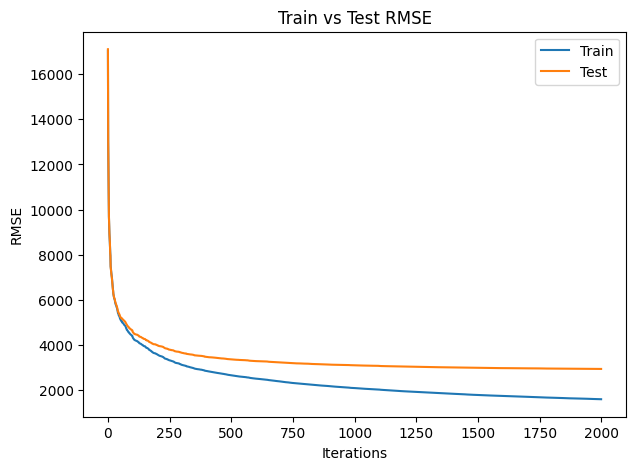

In [33]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
score_hist = pd.DataFrame({'Train_rmse':model.evals_result()['validation_0']['rmse'], 'Test_rmse':model.evals_result()['validation_1']['rmse']})
sns.lineplot(score_hist['Train_rmse'], ax=ax, label='Train')
sns.lineplot(score_hist['Test_rmse'], ax=ax, label='Test')
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.title('Train vs Test RMSE')
plt.show()

In [ ]:
val = pdf.loc[pdf.index >= '2012-05-01']
X_val, y_val = val[FEATURES], val[TARGET]
val['prediction'] = reg.predict(X_val)

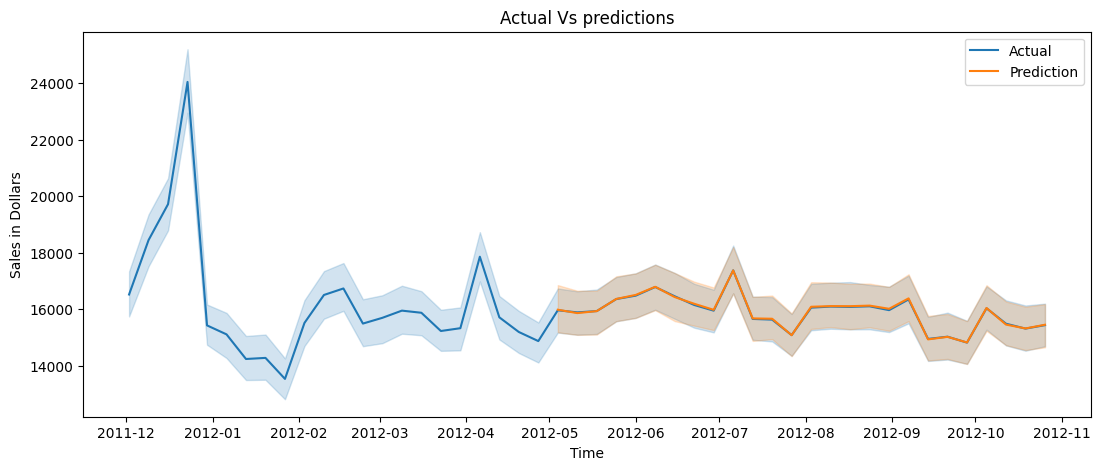

In [39]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['prediction'], ax=ax, label='Prediction')
plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Actual Vs predictions')
plt.show()

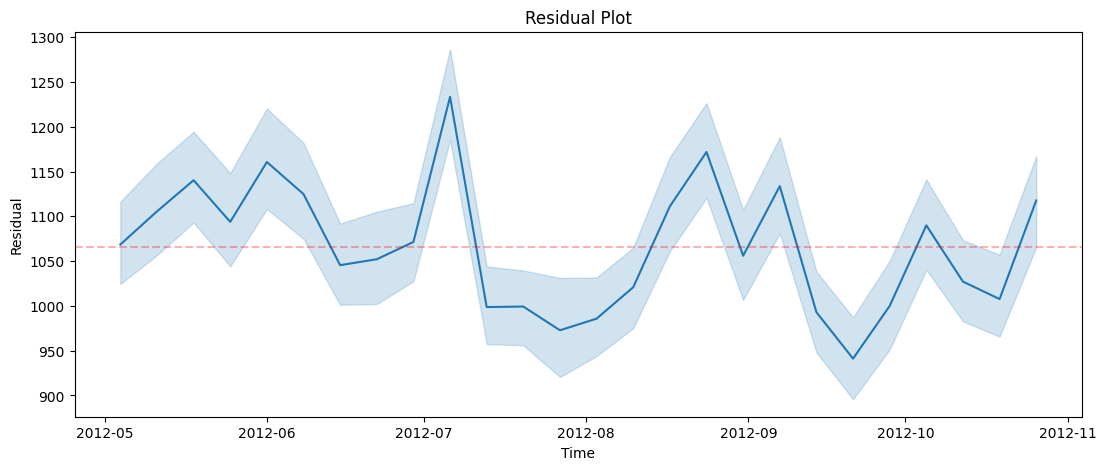

In [45]:
val = val.assign(Residual= abs(val['Weekly_Sales'] - val['prediction']))
fig, ax = plt.subplots(1,1,figsize=(13,5))
#sns.lineplot(pdf['Weekly_Sales'].loc[pdf.index>'2011-12-01'], ax=ax, label='Actual')
sns.lineplot(val['Residual'], ax=ax)
plt.axhline(val['Residual'].mean(), linestyle='--', color='r', alpha=0.3)
#plt.ylabel('Sales in Dollars')
plt.xlabel('Time')
plt.title('Residual Plot')
plt.show()